# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads 2 npz files for your use: labels.npz and images.npz. For those not using colab you can download manually here:

https://drive.google.com/open?id=1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu

https://drive.google.com/open?id=1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0

https://drive.google.com/file/d/1tkpFDxbpP61OEic7EP4LOhUKclYJLlwr/view?usp=sharing

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [31]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='../content/drive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2020')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW2')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
  '1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
  '1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz',
  '1mm5mq7ngx5D2QHFedjucyUC3z0VDeSRj': 'test_y_labels.npz' }      

# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)


Drive already mounted at ../content/drive; to attempt to forcibly remount, call drive.mount("../content/drive", force_remount=True).


# Data Preprocessing

Here you will implement a pytorch data processor that loads tha images and computes the ground truth labels as described in the PDF.


In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def loadData(image_path, labels_path):
  ## use 0.8*no_images as the training data and the remaining as test data.
  images_data = np.load(image_path, allow_pickle=True)
  labels_data = np.load(labels_path, allow_pickle=True, encoding = 'latin1')

  images = images_data['arr_0']
  labels = labels_data['arr_0']

  train_images, test_images, train_raw_labels, test_raw_labels = train_test_split(images, labels, train_size=0.8)
    
  return train_images, train_raw_labels, test_images, test_raw_labels

  # image n*(3,128,128)
  # raw_label(n,5)
  # ground_truth matrix n*8*8*8
  ## this function should compute the 8X8X8 label from the raw labels for the corresponding image.
  # image (3,128,128)
  # raw_label(1,5)
  # ground_truth matrix 8*8*8
def create_y_label(image, raw_label):
  y_label = np.zeros((8,8,8))
  if raw_label.size ==0: return y_label
  for label in raw_label:
    x1,y1,x2,y2=label[1:]
    c_x = (x1+x2)/2
    c_y = (y1+y2)/2

    grid_size_x = int(image.shape[0]/8)
    grid_size_y = int(image.shape[1]/8)

    grid_x = int(c_x/grid_size_x)
    grid_y = int(c_y/grid_size_y)

    offset_x=(c_x%grid_size_x)/grid_size_x
    offset_y=(c_y%grid_size_y)/grid_size_y

    w=(x2-x1)/image.shape[0]
    h=(y2-y1)/image.shape[1]

    label_one_hot=np.zeros(3)
    label_one_hot[int(label[0])]=1

    y_label[0:5,grid_x,grid_y]=[1,offset_x,offset_y,w,h]
    y_label[5:,grid_x,grid_y]=label_one_hot
  return y_label


TEST your processed y_labels.

The following test checks your create_y_labels function using the test_y_label.npz file.

In [33]:
data = np.load("test_y_labels.npz",allow_pickle=True)
## the test data contains 5 - (image, raw_label, processed_label) that is 5 test cases 

img = data['image']   ## shape (5,3,128,18)
raw_label = data['raw_label']
true_y_label = data['y_label']  ## shape (5,8,8,8)

## fill in your code to compute the your processed y_label
y_label = np.zeros((5,8,8,8))

for i, label in enumerate(raw_label):
  y_label[i] = create_y_label(img[i], label)

# test you processed labels
for i in range(len(img)):
  comparison = y_label[i] == true_y_label[i]
  equal_arrays = comparison.all()
  print('Completed TEST CASE {}: {}'.format(i+1,equal_arrays))


Completed TEST CASE 1: True
Completed TEST CASE 2: True
Completed TEST CASE 3: True
Completed TEST CASE 4: True
Completed TEST CASE 5: True


Test your DATASET

Test your data processing by plotting the images and the processed labels. Compare against the raw labels. 

In [59]:
train_images, train_raw_labels, test_images, test_raw_labels = loadData('images.npz', 'labels.npz')

# Q 7.2.1 image with ground truth bounding box

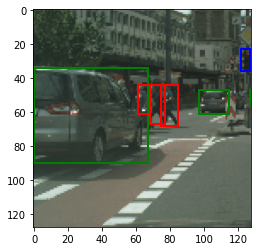

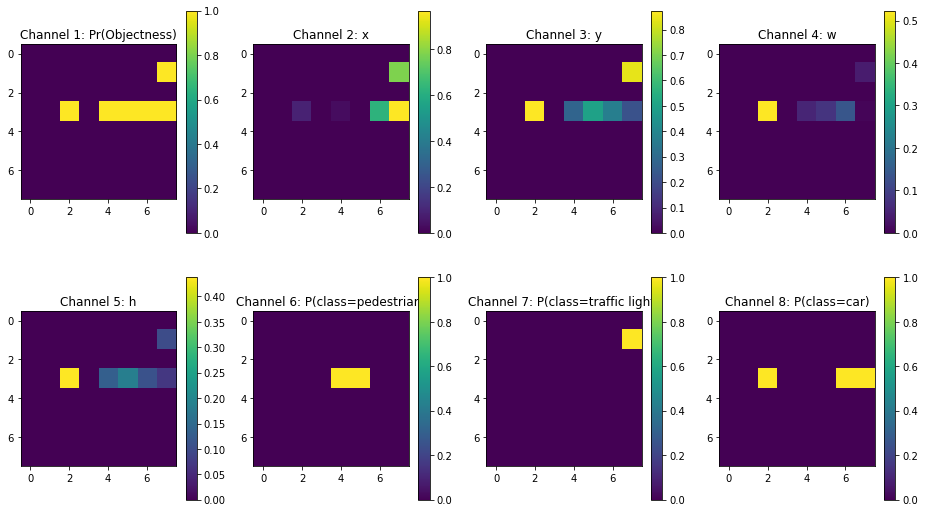

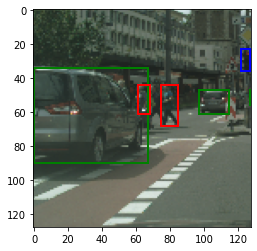

In [60]:
def convert_back_to_raw(grnd_box):
    ## this function should compute raw label from the corresponding 8X8X8 label.
    """
    grnd_box: (8,8,8)
    raw_label: (n,5)
    """
    if np.sum(grnd_box[0]) == 0: return np.array([])

    raw_label = np.zeros((int(np.sum(grnd_box[0])),5))
    indices = np.where(grnd_box[0])
    center_x, center_y, w, h = grnd_box[1][indices], grnd_box[2][indices], grnd_box[3][indices], grnd_box[4][indices]

    raw_label[:, 1] = (center_x * 16 + indices[0] * 16 - w / 2 * 128).astype(np.int32)
    raw_label[:, 2] = (center_y * 16 + indices[1] * 16 - h / 2 * 128).astype(np.int32)
    raw_label[:, 3] = (center_x * 16 + indices[0] * 16 + w / 2 * 128).astype(np.int32)
    raw_label[:, 4] = (center_y * 16 + indices[1] * 16 + h / 2 * 128).astype(np.int32)

    raw_label[:, 0] = grnd_box[5][indices] * 0 + grnd_box[6][indices] * 1 + grnd_box[7][indices] * 2    
    return raw_label

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
for i in range(len(train_images)):     
  cur_label = train_raw_labels[i][:, 0]
  if np.any(cur_label == 0) and np.any(cur_label == 1) and np.any(cur_label == 2):   
    # 7.2.1
    fig = plt.figure()
    plt.imshow(train_images[i])
    ax = plt.gca()
    for j in range(len(train_raw_labels[i])):
        obj = train_raw_labels[i][j]
        x1, y1, x2, y2 = obj[1], obj[2], obj[3], obj[4]
        if obj[0] == 0:
            rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        elif obj[0] == 1:
            rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(rect)
        elif obj[0] == 2:
            rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
    plt.savefig(HOMEWORK_FOLDER+'/raw_label.jpg')

    # 7.2.2
    grnd_box = create_y_label(train_images[i],train_raw_labels[i])
    value_list = ['Pr(Objectness)','x', 'y', 'w', 'h', 'P(class=pedestrian)', 'P(class=traffic light)', 'P(class=car)']
    plt.figure(figsize=(16, 9))
    for k in range(len(grnd_box)):
        plt.subplot(2,4,k+1)
        grid_plot = plt.imshow(grnd_box[k].T, interpolation='nearest')
        colorbar = plt.colorbar()
        plt.title('Channel '+ str(k+1) + ': ' + value_list[k])
    plt.savefig(HOMEWORK_FOLDER+'/8x8x8.jpg')
    
    # 7.2.3
    plt.figure()
    plt.imshow(train_images[i])
    ax = plt.gca()
    back_label = convert_back_to_raw(grnd_box)
    for m in range(len(back_label)):
        obj = back_label[m]
        x1, y1, x2, y2 = obj[1], obj[2], obj[3], obj[4]
        if obj[0] == 0:
            rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        elif obj[0] == 1:
            rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(rect)
        elif obj[0] == 2:
            rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
    plt.savefig(HOMEWORK_FOLDER+'/back_label.jpg')

    break

Set up the data set for training and testing.

In [41]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

## use the processed labels and use the correct image dimensions for the pytorch loader.
## images = images.transpose(0,3,1,2)

class YOLODataset(TensorDataset):
    """
    TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform is not None:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

BATCH_SIZE = 64
# train_images, train_raw_labels, test_images, test_raw_labels = loadData('images.npz', 'labels.npz')
train_labels = np.zeros((len(train_images), 8, 8, 8))
for i in range(len(train_images)):
    train_labels[i] = create_y_label(train_images[i], train_raw_labels[i])
train_dataset = YOLODataset((torch.Tensor(train_images.transpose(0,3,1,2)) , torch.Tensor(train_labels)), 
                              transform=transforms.Compose([transforms.Normalize((0.5,), (0.5,))]))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

test_labels = np.zeros((len(test_images), 8, 8, 8))
for i in range(len(test_images)):
    test_labels[i] = create_y_label(test_images[i], test_raw_labels[i])
test_dataset = YOLODataset((torch.Tensor(test_images.transpose(0,3,1,2)) , torch.Tensor(test_labels)), 
                              transform=transforms.Compose([transforms.Normalize((0.5,), (0.5,))]))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Model Definition

In [42]:
class YOLO(torch.nn.Module):
    def __init__(self):
        super(YOLO, self).__init__() # 128x128x3
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(4, 4), stride=2, padding=1), # 64x64x32
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 64, kernel_size=(4, 4), stride=2, padding=1), # 32x32x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=2, padding=1), # 16x16x128
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=2, padding=1), # 8x8x256
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Conv2d(256, 512, kernel_size=(4, 4), stride=2, padding=1), # 4x4x512
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.Conv2d(512, 1024, kernel_size=(4, 4), stride=2, padding=1), # 2x2x1024
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=2, padding=1), # 4x4x256
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=2, padding=1), # 8x8x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 8, kernel_size=(3, 3), stride=1, padding=1), # 8x8x8
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.conv(X)

# Training you network

Start by defining the 
1. IOU
2. appropropriate loss function.
3. NMS - non-max suppression function
4. Average precision function

Please define additional functions as needed.

In [43]:
def IOU(bbox_1 ,bbox_2):
  x_1up=bbox_1[0]
  y_1up=bbox_1[1]
  x_1l=bbox_1[2]
  y_1l=bbox_1[3]

  x_2up=bbox_2[0]
  y_2up=bbox_2[1]
  x_2l=bbox_2[2]
  y_2l=bbox_2[3]

  x_up=max(x_1up,x_2up)
  y_up=max(y_1up,y_2up)

  x_l=min(x_1l,x_2l)
  y_l=min(y_1l,y_2l)

  inter_area = max((x_l-x_up),0) * max((y_l-y_up),0)

  area_box1 = max((x_1l-x_1up),0) * max((y_1l-y_1up),0)
  area_box2 = max((x_2l-x_2up),0) * max((y_2l-y_2up),0)
  union_area=area_box1+area_box2-inter_area
  iou=(inter_area+ 1e-3)/(union_area+1e-3)  

  return iou

def decode_box(code,objects):
  x,y,w,h=code[1:5]
  re_w=w*128  #128
  re_h=h*128
  re_x=x*16
  re_y=y*16
  grid_x=objects[1]
  grid_y=objects[2]
  box=torch.zeros(4)
  box[0]=grid_x*16 + re_x-re_w/2
  box[1]=grid_y*16 + re_y-re_h/2
  box[2]=grid_x*16 + re_x+re_w/2
  box[3]=grid_y*16 + re_y+re_h/2  #offset maybe not necessary
  return box

def calc_confidence_score(prediction, grnd_truth,objects):
  ## please fill in additional arguements
  num_objects=prediction.shape[0]
  C_true=torch.zeros(num_objects)
  for i in range(num_objects):
  ## for each object compute the predicted bounding box and grnd_truth bounding box
    predicted_bbox = decode_box(prediction[i,:],objects[i,:])  
    grnd_truth_bbox = decode_box(grnd_truth[i,:],objects[i,:])
  ## next compute the iou of the predicted_bbox and the grnd_truth_bbox
    iou = IOU(predicted_bbox,grnd_truth_bbox)
    C_true[i] = iou
  return C_true.to(device)


def YoloLoss(output, target, lambda_coord, lambda_noobj):
  ## please fill in additional arguements
  objects=target[:,0,:,:].nonzero()
  non_objects=(target[:,0,:,:]==0).nonzero()

  target_objects=target[objects[:,0],:,objects[:,1],objects[:,2]]
  predicted_objects=output[objects[:,0],:,objects[:,1],objects[:,2]]
  non_predicted_objects=output[non_objects[:,0],:,non_objects[:,1],non_objects[:,2]]

  locl_c=torch.sum((target_objects[:,1]-predicted_objects[:,1])**2+(target_objects[:,2]-predicted_objects[:,2])**2)
  locl_w=torch.sum((torch.sqrt(target_objects[:,3])-torch.sqrt(predicted_objects[:,3]))**2 + (torch.sqrt(target_objects[:,4])-torch.sqrt(predicted_objects[:,4]))**2)

  conf=calc_confidence_score(predicted_objects,target_objects,objects)

  loss_conf_object=torch.sum((conf[:]-predicted_objects[:,0])**2)
  loss_conf_no_object=torch.sum((non_predicted_objects[:,0])**2)
  
  # l2 norm and sum
  loss_class=torch.sum((target_objects[:,5]-predicted_objects[:,5])**2+(target_objects[:,6]-predicted_objects[:,6])**2+(target_objects[:,7]-predicted_objects[:,7])**2)

  loss=lambda_coord*(locl_c+locl_w)+loss_conf_object+lambda_noobj*loss_conf_no_object+loss_class
  return loss

def average_precision():
    ## please fill in the appropriate arguements 
    ## compute the average precision as mentioned in the PDF.
    ## it might be helpful to use - from sklearn.metrics import auc to compute area under the curve.
    pass


**Train your network **

We suggest that you save checkpoints sand reload from the most recent. This is due time constraints within Colab


In [52]:
import torch.nn as nn
device = torch.device('cuda:0')
torch.manual_seed(0)

yolo_net=YOLO()
yolo_net=yolo_net.to(device)
learning_rate = 10e-3 

## intialize optimizer
optimizer=torch.optim.Adam(yolo_net.parameters(),lr=learning_rate,weight_decay=0.0006)
num_epochs = 40 ## intialize this, atleast 20 epoch required for training
log_interval = 1000
train_losses = []
check_num=10
for epoch in range(num_epochs):
    ## fill in your training code
    yolo_net.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = yolo_net(data)
        loss = YoloLoss(output, target, lambda_coord=5, lambda_noobj=0.5)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(epoch_loss)
    print('Epoch:{} Avg. loss: {:.4f}'.format(epoch + 1, epoch_loss))
    if epoch % check_num == 9:
      path = HOMEWORK_FOLDER+'/yolo_epoch_'+str(epoch)
      torch.save({
              'epoch': epoch,
              'model_state_dict': yolo_net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()
              }, path)	


Epoch:1 Avg. loss: 5.9994
Epoch:2 Avg. loss: 5.1335
Epoch:3 Avg. loss: 4.6277
Epoch:4 Avg. loss: 4.1350
Epoch:5 Avg. loss: 3.7583
Epoch:6 Avg. loss: 3.5116
Epoch:7 Avg. loss: 3.2926
Epoch:8 Avg. loss: 3.1169
Epoch:9 Avg. loss: 2.8938
Epoch:10 Avg. loss: 2.6855
Epoch:11 Avg. loss: 2.4625
Epoch:12 Avg. loss: 2.2359
Epoch:13 Avg. loss: 2.0230
Epoch:14 Avg. loss: 1.8069
Epoch:15 Avg. loss: 1.6244
Epoch:16 Avg. loss: 1.4771
Epoch:17 Avg. loss: 1.3257
Epoch:18 Avg. loss: 1.2284
Epoch:19 Avg. loss: 1.1224
Epoch:20 Avg. loss: 1.0784
Epoch:21 Avg. loss: 1.0233
Epoch:22 Avg. loss: 1.0111
Epoch:23 Avg. loss: 1.0052
Epoch:24 Avg. loss: 0.9684
Epoch:25 Avg. loss: 0.9511
Epoch:26 Avg. loss: 0.9315
Epoch:27 Avg. loss: 0.8772
Epoch:28 Avg. loss: 0.8614
Epoch:29 Avg. loss: 0.8294
Epoch:30 Avg. loss: 0.8408
Epoch:31 Avg. loss: 0.8031
Epoch:32 Avg. loss: 0.8012
Epoch:33 Avg. loss: 0.8130
Epoch:34 Avg. loss: 0.8028
Epoch:35 Avg. loss: 0.7537
Epoch:36 Avg. loss: 0.7500
Epoch:37 Avg. loss: 0.7679
Epoch:38 A

In [ ]:
resume = False # set this True if you want to resume training from a checkpoint
if resume == True:
  checkpoint = torch.load(path)
  yolo_net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']

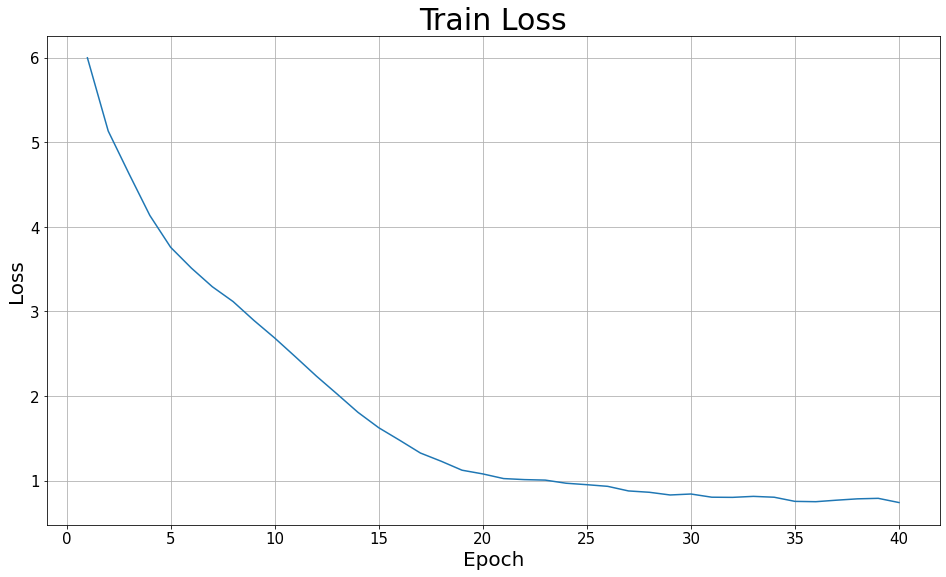

In [54]:
plt.figure(figsize=(16,9))
plt.plot(np.arange(1, num_epochs + 1), np.array(train_losses))
plt.tick_params(labelsize=15)
plt.title('Train Loss', fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.grid(b=True)
plt.savefig(HOMEWORK_FOLDER+'/train_loss.jpg')
plt.show()

# Test your network.
Use the test images you created in the data preprocessing step. 


In [55]:
# path = ## intialise the path where the model has been saved 
# checkpoint = torch.load(path)
# yolo_net.load_state_dict(checkpoint['model_state_dict'])
yolo_net.eval()
running_loss = 0.0
for batch_idx, (data, target) in enumerate(test_dataloader):
    data, target = data.to(device), target.to(device)
    output = yolo_net(data)
    loss = YoloLoss(output, target, lambda_coord=5, lambda_noobj=0.5)
    running_loss += loss.item()

running_loss = running_loss / len(test_dataloader.dataset)
print('Epoch:{} Avg. loss: {:.4f}'.format(epoch + 1, running_loss))


Epoch:40 Avg. loss: 3.0669
